In [21]:
#bibliotecas
import matplotlib.pyplot as plt
import numpy as np
import os
import glob


from astropy.modeling import models
from astropy import units as u
from astropy import nddata
from astropy.io import fits
from astropy.visualization import hist


import ccdproc as ccdp
from ccdproc import CCDData
from pathlib import Path
from ccdproc import ImageFileCollection
from astropy.stats import mad_std
from scipy import stats
import msumastro 
from scipy.stats import mode

In [22]:
#Set some properties of the instrument that took these images...

gain = 1.47 * u.electron / u.adu
readnoise = 29 * u.electron  # wish it wasn't, but it really seems to be...

In [23]:
#FUNCTIONS
def oscan_and_trim(image_list):
    """
    Remove overscan and trim a list of images. The original list is replaced by a list of images
    with the changes applied.
    """
    for idx, img in enumerate(image_list):
        oscan = ccdproc.subtract_overscan(img, img[:, 3075:3079], add_keyword={'oscan_sub': True, 'calstat': 'O'}, model=models.Polynomial1D(1))
        image_list[idx] = ccdproc.trim_image(oscan[:, :3073], add_keyword={'trimmed': True, 'calstat': 'OT'})

#A bottleneck-based replacement for a stack (i.e. list) of masked arrays

def bn_median(masked_array, axis=None):
    """
    Perform fast median on masked array
    
    Parameters
    ----------
    
    masked_array : `numpy.ma.masked_array`
        Array of which to find the median.
    
    axis : int, optional
        Axis along which to perform the median. Default is to find the median of
        the flattened array.
    """
    data = masked_array.filled(fill_value=np.NaN)
    med = bn.nanmedian(data, axis=axis)
    # construct a masked array result, setting the mask from any NaN entries
    return np.ma.array(med, mask=np.isnan(med))

def avg_over_images(masked_arr, axis=0):
    """
    Calculate average pixel value along specified axis
    """
    return ma.mean(masked_arr, axis=axis)

def med_over_images(masked_arr, axis=0):
    """
    Calculate median pixel value along specified axis
    
    Uses bottleneck.nanmedian for speed
    """
    
    dat = masked_arr.data.copy()
    dat[masked_arr.mask] = np.NaN
    return bn.nanmedian(dat, axis=axis)


# Função show_image deve ser definida ou importada
def show_image(data, cmap='gray', ax=None, fig=None, percl=99):
    """Exibe uma imagem usando Matplotlib com base em percentis para escala de cor."""
    if ax is None:
        ax = plt.gca()
    if fig is None:
        fig = plt.gcf()
    
    vmin, vmax = np.percentile(data, (100 - percl, percl))
    img = ax.imshow(data, cmap=cmap, origin='lower', vmin=vmin, vmax=vmax)
    fig.colorbar(img, ax=ax, orientation='vertical')
    ax.set_xticks([])
    ax.set_yticks([])
    return img



In [24]:
#c. A little function for displaying image statistics....
#...which is useful for determining scale when displaying an image.
imstats = lambda dat: (dat.min(), dat.max(), dat.mean(), dat.std())

In [27]:
#TABELA DE ARQUIVOS
# 
data_dir = '/home/astroesul/Downloads/matheus/treinoM104'
image_files = glob.glob(os.path.join(data_dir, '*.fits'))
data_path = Path(data_dir)
files = ImageFileCollection(data_path)
# Gera o resumo das informações dos arquivos
summary = files.summary['file', 'imagetyp', 'filter', 'exptime', 'naxis1', 'naxis2']
#summary = files.summary['file', 'imagetyp', 'filter', 'naxis1', 'naxis2']
# Exibe o resumo
print(summary)

     file     imagetyp     filter    exptime naxis1 naxis2
------------- -------- ------------- ------- ------ ------
 bias001.fits     BIAS            --      --    748    577
 bias002.fits     BIAS            --      --    748    577
 dark001.fits     DARK            --      --    748    577
 dark002.fits     DARK            --      --    748    577
 dark003.fits     DARK            --      --    748    577
 dark004.fits     DARK            --      --    748    577
 flat001.fits     FLAT            --      --    748    577
 flat002.fits     FLAT            --      --    748    577
 flat003.fits     FLAT            --      --    748    577
light111.fits    LIGHT             v      15    748    577
 light22.fits    LIGHT Not specified     4.0    748    577


In [28]:
#redimensiona fits
# Diretório com os arquivos FITS
data_dir = '/home/astroesul/Downloads/matheus/treinoM104'
image_files = glob.glob(os.path.join(data_dir, '*.fits'))

# Função para redimensionar ou cortar a imagem
def resize_image(data, target_shape):
    naxis1, naxis2 = target_shape
    original_shape = data.shape

    if original_shape[0] < naxis1 or original_shape[1] < naxis2:
        # Expandir a imagem com zero-padding se for menor
        padded_data = np.zeros((naxis1, naxis2))
        padded_data[:original_shape[0], :original_shape[1]] = data
        return padded_data
    else:
        # Cortar a imagem para o tamanho desejado
        return data[:naxis1, :naxis2]

# Encontre as dimensões desejadas (baseado no menor tamanho comum)
naxis1_target = None
naxis2_target = None

# Encontrar dimensões mínimas comuns
for file in image_files:
    with fits.open(file) as hdul:
        data = hdul[0].data
        naxis1, naxis2 = data.shape
        if naxis1_target is None or naxis2_target is None:
            naxis1_target, naxis2_target = naxis1, naxis2
        else:
            naxis1_target = min(naxis1_target, naxis1)
            naxis2_target = min(naxis2_target, naxis2)

# Redimensionar ou cortar todos os arquivos para as dimensões mínimas
for file in image_files:
    with fits.open(file) as hdul:
        data = hdul[0].data
        resized_data = resize_image(data, (naxis1_target, naxis2_target))
        
        # Salvar o arquivo modificado
        hdul[0].data = resized_data
        hdul.writeto(file, overwrite=True)

print(f'Todos os arquivos foram redimensionados para {naxis1_target}x{naxis2_target}.')


Todos os arquivos foram redimensionados para 577x748.


In [29]:
#TABELA DE ARQUIVOS
# 
data_dir = '/home/astroesul/Downloads/matheus/treinoM104'
image_files = glob.glob(os.path.join(data_dir, '*.fits'))
data_path = Path(data_dir)
files = ImageFileCollection(data_path)
# Gera o resumo das informações dos arquivos
summary = files.summary['file', 'imagetyp', 'filter', 'exptime', 'naxis1', 'naxis2']
#summary = files.summary['file', 'imagetyp', 'filter', 'naxis1', 'naxis2']
# Exibe o resumo
print(summary)

     file     imagetyp     filter    exptime naxis1 naxis2
------------- -------- ------------- ------- ------ ------
 bias001.fits     BIAS            --      --    748    577
 bias002.fits     BIAS            --      --    748    577
 dark001.fits     DARK            --      --    748    577
 dark002.fits     DARK            --      --    748    577
 dark003.fits     DARK            --      --    748    577
 dark004.fits     DARK            --      --    748    577
 flat001.fits     FLAT            --      --    748    577
 flat002.fits     FLAT            --      --    748    577
 flat003.fits     FLAT            --      --    748    577
light111.fits    LIGHT             v      15    748    577
 light22.fits    LIGHT Not specified     4.0    748    577


In [30]:
bias_list = []
# Itera sobre os arquivos encontrados
for fname in image_files:
    with fits.open(fname) as hdulist:
        # Itera sobre todas as extensões no arquivo FITS
        for hdu in hdulist:
            # Verifica se o tipo de imagem é 'bias'
            if 'bias' in hdu.header.get('IMAGETYP', '').lower():
                # Cria um dicionário para os metadados
                meta = hdu.header.copy()  # Copia o cabeçalho para os metadados
                meta['filename'] = fname  # Adiciona o nome do arquivo aos metadados
                
                # Cria um objeto CCDData e adiciona à lista
                bias_list.append(CCDData(data=hdu.data, meta=meta, unit="adu"))

# Exibe a lista de arquivos bias encontrados
for bias in bias_list:
    print(f"Filename: {bias.meta['filename']}")

Filename: /home/astroesul/Downloads/matheus/treinoM104/bias001.fits
Filename: /home/astroesul/Downloads/matheus/treinoM104/bias002.fits


In [31]:
dark_list = []
# Itera sobre os arquivos encontrados
for fname in image_files:
    with fits.open(fname) as hdulist:
        # Itera sobre todas as extensões no arquivo FITS
        for hdu in hdulist:
            # Verifica se o tipo de imagem é 'dark'
            if 'dark' in hdu.header.get('IMAGETYP', '').lower():
                # Cria um dicionário para os metadados
                meta = hdu.header.copy()  # Copia o cabeçalho para os metadados
                meta['filename'] = fname  # Adiciona o nome do arquivo aos metadados
                
                # Cria um objeto CCDData e adiciona à lista
                dark_list.append(CCDData(data=hdu.data, meta=meta, unit="adu"))

for dark in dark_list:
    print(f"Filename: {dark.meta['filename']}")

Filename: /home/astroesul/Downloads/matheus/treinoM104/dark002.fits
Filename: /home/astroesul/Downloads/matheus/treinoM104/dark004.fits
Filename: /home/astroesul/Downloads/matheus/treinoM104/dark001.fits
Filename: /home/astroesul/Downloads/matheus/treinoM104/dark003.fits


In [32]:
#FAZE MASTER_BIAS E MASTER_DARK

# Combina as imagens de bias usando ccdproc
master_bias = ccdp.combine(bias_list,
                             method='average',
                             sigma_clip=True, sigma_clip_low_thresh=5, sigma_clip_high_thresh=5,
                             sigma_clip_func=np.ma.median, sigma_clip_dev_func=mad_std,
                             mem_limit=350e6
                            )

master_bias.meta['combined'] = True
master_bias.write('/home/astroesul/Downloads/matheus/treinoM104/master_bias.fits', overwrite=True) 

# Combina as imagens de dark usando ccdproc
master_dark = ccdp.combine(dark_list,
                             method='average',
                             sigma_clip=True, sigma_clip_low_thresh=5, sigma_clip_high_thresh=5,
                             sigma_clip_func=np.ma.median, sigma_clip_dev_func=mad_std,
                             mem_limit=350e6
                            )


master_dark.meta['combined'] = True
master_dark.write('/home/astroesul/Downloads/matheus/treinoM104/master_dark.fits', overwrite=True) 


FileNotFoundError: [Errno 2] No such file or directory: '/home/Downloads/matheus/treinoM104/master_dark.fits'

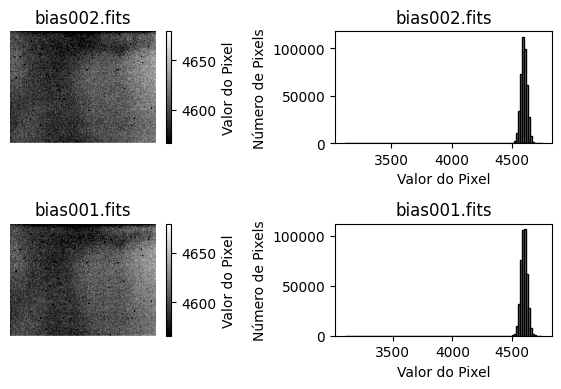

In [ ]:
#PLOTAR TODOS OS BIAS E MASTERBIAS
#  Preencher bias_list com os dados de imagem 'bias'
bias_list = []
for fname in image_files:
    with fits.open(fname) as hdulist:
        # Itera sobre todas as extensões no arquivo FITS
        for hdu in hdulist:
            # Verifica se o tipo de imagem é 'bias'
            if 'bias' in hdu.header.get('IMAGETYP', '').lower():
                # Cria um dicionário para os metadados
                meta = hdu.header.copy()  # Copia o cabeçalho para os metadados
                meta['filename'] = os.path.basename(fname)  # Adiciona o nome do arquivo aos metadados
                
                # Cria um objeto CCDData e adiciona à lista
                bias_list.append(CCDData(data=hdu.data, meta=meta, unit="adu"))

# Verifica se bias_list não está vazio
if bias_list:
    # Configurar a figura para múltiplos subplots (imagem e histograma lado a lado)
    num_bias = len(bias_list)
    fig, axes = plt.subplots(num_bias, 2, figsize=(6, 2 * num_bias))

    # Loop para plotar cada imagem e histograma
    for i, bias in enumerate(bias_list):
        image_data = bias.data
        filename = bias.meta['filename']  # Nome do arquivo

        # Definir os valores mínimo e máximo para o colormap
        vmin, vmax = np.percentile(image_data, (10, 99.8))  # Ajusta os percentis conforme necessário

        # Plotar a imagem FITS
        ax_img = axes[i, 0]  # Acessa o subplot correspondente
        im = ax_img.imshow(image_data, cmap='gray', origin='lower', vmin=vmin, vmax=vmax)
        ax_img.set_title(filename)  # Apenas o nome do arquivo
        ax_img.axis('off')
        cbar = plt.colorbar(im, ax=ax_img)
        cbar.set_label('Valor do Pixel')

        # Plotar o histograma
        ax_hist = axes[i, 1]  # Acessa o subplot correspondente
        ax_hist.hist(image_data.flatten(), bins=100, color='gray', edgecolor='black')
        ax_hist.set_title(filename)  # Apenas o nome do arquivo
        ax_hist.set_xlabel('Valor do Pixel')
        ax_hist.set_ylabel('Número de Pixels')

    # Ajustar o layout da figura
    plt.tight_layout()
    plt.show()
else:
    print("Nenhuma imagem 'bias' encontrada.")

Filename: /home/meteoro/Documentos/treinoM104/bias002.fits
Filename: /home/meteoro/Documentos/treinoM104/bias001.fits


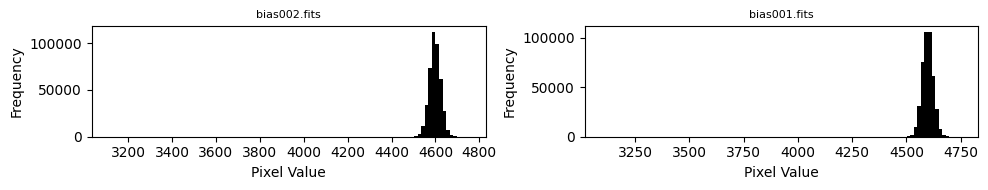

In [ ]:
#SOMENTE OS HISTOGRAMAS DE TODOS OS BIAS


# Supondo que bias_list já foi preenchida com objetos CCDData
bias_list = []

# Itera sobre os arquivos encontrados
for fname in image_files:
    with fits.open(fname) as hdulist:
        # Itera sobre todas as extensões no arquivo FITS
        for hdu in hdulist:
            # Verifica se o tipo de imagem é 'bias'
            if 'bias' in hdu.header.get('IMAGETYP', '').lower():
                # Cria um dicionário para os metadados
                meta = hdu.header.copy()  # Copia o cabeçalho para os metadados
                meta['filename'] = fname  # Adiciona o nome do arquivo aos metadados
                
                # Cria um objeto CCDData e adiciona à lista
                bias_list.append(CCDData(data=hdu.data, meta=meta, unit="adu"))

# Exibe a lista de arquivos bias encontrados
for bias in bias_list:
    print(f"Filename: {bias.meta['filename']}")

# Define o número de colunas para os subplots
num_cols = 2
num_plots = len(bias_list)
num_rows = int(np.ceil(num_plots / num_cols))

# Cria uma figura com subplots, ajustando o tamanho
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 2 * num_rows))
axes = axes.flatten()  # Facilita o acesso aos eixos

# Plota o histograma para cada imagem de bias
for i, bias in enumerate(bias_list):
    # Gera o histograma
    axes[i].hist(bias.data.flatten(), bins=100, color='black')
    # Extrai apenas o nome do arquivo sem o caminho
    file_name = os.path.basename(bias.meta['filename'])
    axes[i].set_title(file_name, fontsize=8)
    axes[i].set_xlabel("Pixel Value")
    axes[i].set_ylabel("Frequency")

# Remove os eixos extras se houver menos imagens do que subplots
for j in range(num_plots, len(axes)):
    fig.delaxes(axes[j])

# Ajusta o layout para não sobrepor os títulos e labels
plt.tight_layout()

# Exibe os histogramas
plt.show()

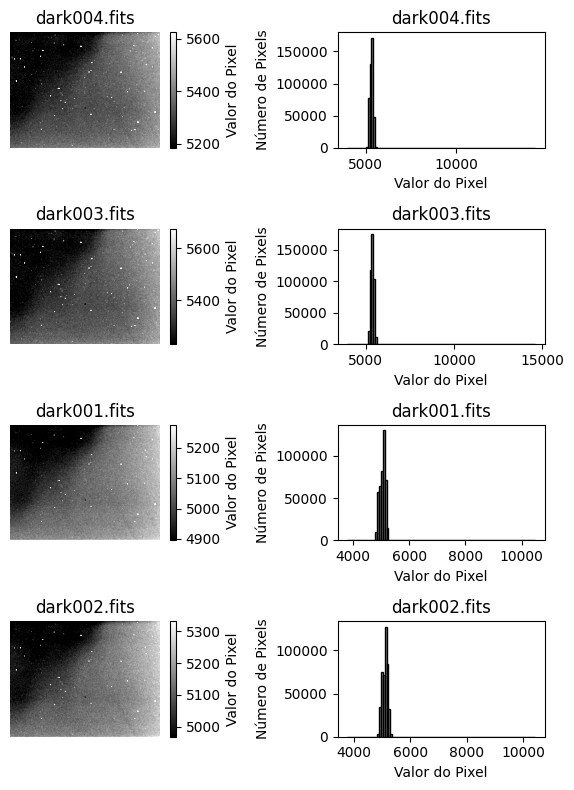

In [ ]:
# PLOTAR TODOS OS DARKS E MASTER DARK
dark_list = []
for fname in image_files:
    with fits.open(fname) as hdulist:
        # Itera sobre todas as extensões no arquivo FITS
        for hdu in hdulist:
            # Verifica se o tipo de imagem é 'dark'
            if 'dark' in hdu.header.get('IMAGETYP', '').lower():
                # Cria um dicionário para os metadados
                meta = hdu.header.copy()  # Copia o cabeçalho para os metadados
                # Extrai apenas o nome do arquivo sem o caminho
                meta['filename'] = os.path.basename(fname)  # Adiciona o nome do arquivo aos metadados
                
                # Cria um objeto CCDData e adiciona à lista
                dark_list.append(CCDData(data=hdu.data, meta=meta, unit="adu"))

# Verifica se dark_list não está vazio
if dark_list:
    # Configurar a figura para múltiplos subplots (imagem e histograma lado a lado)
    num_dark = len(dark_list)
    fig, axes = plt.subplots(num_dark, 2, figsize=(6, 2 * num_dark))

    # Loop para plotar cada imagem e histograma
    for i, dark in enumerate(dark_list):
        image_data = dark.data
        filename = dark.meta['filename']  # Nome do arquivo

        # Definir os valores mínimo e máximo para o colormap
        vmin, vmax = np.percentile(image_data, (10, 99.8))  # Ajusta os percentis conforme necessário

        # Plotar a imagem FITS
        ax_img = axes[i, 0]  # Acessa o subplot correspondente
        im = ax_img.imshow(image_data, cmap='gray', origin='lower', vmin=vmin, vmax=vmax)
        ax_img.set_title(filename)  # Apenas o nome do arquivo
        ax_img.axis('off')
        cbar = plt.colorbar(im, ax=ax_img)
        cbar.set_label('Valor do Pixel')

        # Plotar o histograma
        ax_hist = axes[i, 1]  # Acessa o subplot correspondente
        ax_hist.hist(image_data.flatten(), bins=100, color='gray', edgecolor='black')
        ax_hist.set_title(filename)  # Apenas o nome do arquivo
        ax_hist.set_xlabel('Valor do Pixel')
        ax_hist.set_ylabel('Número de Pixels')

    # Ajustar o layout da figura
    plt.tight_layout()
    plt.show()
else:
    print("Nenhuma imagem 'dark' encontrada.")

Filename: /home/meteoro/Documentos/treinoM104/dark004.fits
Filename: /home/meteoro/Documentos/treinoM104/dark003.fits
Filename: /home/meteoro/Documentos/treinoM104/dark001.fits
Filename: /home/meteoro/Documentos/treinoM104/dark002.fits


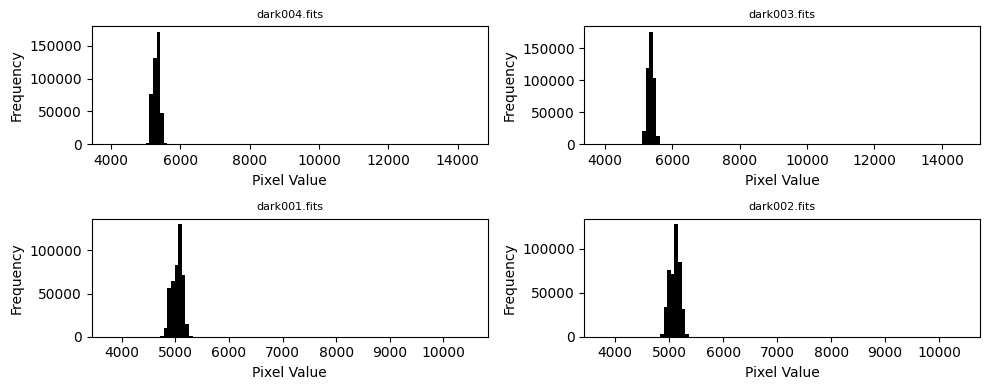

In [ ]:
# HISTOGRAMA DE TODOS OS DARKS


# Supondo que dark_list será preenchida com objetos CCDData
dark_list = []

# Itera sobre os arquivos encontrados
for fname in image_files:
    with fits.open(fname) as hdulist:
        # Itera sobre todas as extensões no arquivo FITS
        for hdu in hdulist:
            # Verifica se o tipo de imagem é 'dark'
            if 'dark' in hdu.header.get('IMAGETYP', '').lower():
                # Cria um dicionário para os metadados
                meta = hdu.header.copy()  # Copia o cabeçalho para os metadados
                meta['filename'] = fname  # Adiciona o nome do arquivo aos metadados
                
                # Cria um objeto CCDData e adiciona à lista
                dark_list.append(CCDData(data=hdu.data, meta=meta, unit="adu"))

# Exibe a lista de arquivos dark encontrados
for dark in dark_list:
    print(f"Filename: {dark.meta['filename']}")

# Define o número de colunas para os subplots
num_cols = 2
num_plots = len(dark_list)
num_rows = int(np.ceil(num_plots / num_cols))

# Cria uma figura com subplots, ajustando o tamanho
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 2 * num_rows))
axes = axes.flatten()  # Facilita o acesso aos eixos

# Plota o histograma para cada imagem de dark
for i, dark in enumerate(dark_list):
    # Gera o histograma
    axes[i].hist(dark.data.flatten(), bins=100, color='black')
    # Extrai apenas o nome do arquivo sem o caminho
    file_name = os.path.basename(dark.meta['filename'])
    axes[i].set_title(file_name, fontsize=8)
    axes[i].set_xlabel("Pixel Value")
    axes[i].set_ylabel("Frequency")

# Remove os eixos extras se houver menos imagens do que subplots
for j in range(num_plots, len(axes)):
    fig.delaxes(axes[j])

# Ajusta o layout para não sobrepor os títulos e labels
plt.tight_layout()

# Exibe os histogramas
plt.show()

In [ ]:
#FLAT_LIST
flat_list = []

# Itera sobre os arquivos encontrados
for fname in image_files:
    with fits.open(fname) as hdulist:
        # Itera sobre todas as extensões no arquivo FITS
        for hdu in hdulist:
            # Verifica se o tipo de imagem é 'light'
            if 'flat' in hdu.header.get('IMAGETYP', '').lower():
                # Cria um dicionário para os metadados
                meta = hdu.header.copy()  # Copia o cabeçalho para os metadados
                meta['filename'] = fname  # Adiciona o nome do arquivo aos metadados

                flat_list.append(ccdp.CCDData(data=hdu.data, meta=meta, unit="adu"))
for flat in flat_list:
    print(f"Filename: {flat.meta['filename']}")

Filename: /home/meteoro/Documentos/treinoM104/flat003.fits
Filename: /home/meteoro/Documentos/treinoM104/flat002.fits
Filename: /home/meteoro/Documentos/treinoM104/flat001.fits


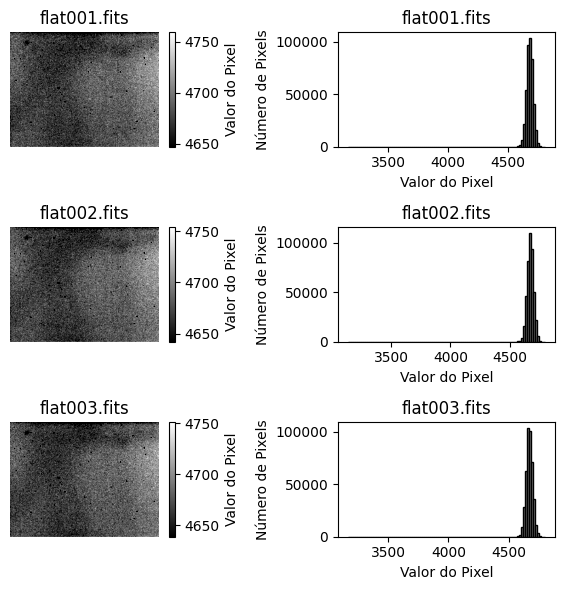

In [ ]:
#PLOTAR FLATS LIST

# Lista de caminhos dos arquivos FITS
file_paths = [
    '/home/astroesul/Downloads/matheus/treinoM104/flat001.fits',
    '/home/astroesul/Downloads/matheus/treinoM104/flat002.fits',
    '/home/astroesul/Downloads/matheus/treinoM104/flat003.fits',
]

# Configurar a figura para múltiplos subplots (imagem e histograma lado a lado)
num_flats = len(file_paths)
fig, axes = plt.subplots(num_flats, 2, figsize=(6, 2 * num_flats))

# Loop através dos arquivos FITS
for i, file_path in enumerate(file_paths):
    # Ler os dados da imagem FITS
    with fits.open(file_path) as hdul:
        image_data = CCDData(hdul[0].data, meta=hdul[0].header, unit='adu').data
    
    # Definir os valores mínimo e máximo para o colormap
    vmin, vmax = np.percentile(image_data, (10, 99.8))  # Ajusta os percentis conforme necessário
    
    # Extrair apenas o nome do arquivo sem o caminho
    file_name = os.path.basename(file_path)
    
    # Plotar a imagem FITS
    ax_img = axes[i, 0] if num_flats > 1 else axes[0]  # Ajusta para um único subplot se necessário
    im = ax_img.imshow(image_data, cmap='gray', origin='lower', vmin=vmin, vmax=vmax)
    ax_img.set_title(file_name)  # Apenas o nome do arquivo
    ax_img.axis('off')
    cbar = plt.colorbar(im, ax=ax_img)
    cbar.set_label('Valor do Pixel')

    # Plotar o histograma
    ax_hist = axes[i, 1] if num_flats > 1 else axes[1]  # Ajusta para um único subplot se necessário
    ax_hist.hist(image_data.flatten(), bins=100, color='gray', edgecolor='black')
    ax_hist.set_title(file_name)  # Apenas o nome do arquivo
    ax_hist.set_xlabel('Valor do Pixel')
    ax_hist.set_ylabel('Número de Pixels')

# Ajustar o layout da figura
plt.tight_layout()
plt.show()

In [ ]:
#FAZER FLAT - MASTER_DARK


# Caminho para o arquivo FITS de referência
dark_file = '/home/astroesul/Downloads/matheus/treinoM104/master_dark.fits'

# Lista para armazenar os dados de imagem
flat_list = []

# Itera sobre os arquivos encontrados
for fname in image_files:
    with fits.open(fname) as hdulist:
        # Itera sobre todas as extensões no arquivo FITS
        for hdu in hdulist:
            # Verifica se o tipo de imagem é 'flat'
            if 'flat' in hdu.header.get('IMAGETYP', '').lower():
                # Cria um dicionário para os metadados
                meta = hdu.header.copy()  # Copia o cabeçalho para os metadados
                meta['filename'] = fname  # Adiciona o nome do arquivo aos metadados
                
                # Cria um objeto CCDData e adiciona à lista
                flat_list.append(CCDData(data=hdu.data, meta=meta, unit="adu"))

# Exibe a lista de arquivos flat encontrados
for flat in flat_list:
    print(f"Filename: {flat.meta['filename']}")

# Abre o arquivo de referência (combined_dark.fits)
with fits.open(dark_file) as dark_hdu:
    dark_data = dark_hdu[2].data  # Supondo que os dados estão na extensão 

# Diretório de saída
output_directory = '/home/astroesul/Downloads/matheus/treinoM104/'

# Itera sobre a lista de imagens flat e realiza a subtração
for flat in flat_list:
    # Verifica se os dados do arquivo de referência e o flat têm o mesmo formato
    if dark_data.shape != flat.data.shape:
        raise ValueError(f"Shape mismatch: dark file shape {dark_data.shape} vs flat file shape {flat.data.shape}")

    # Subtrai os dados do arquivo de referência dos dados do flat
    result_data = flat.data - dark_data

    # Cria um novo HDU com os dados resultantes
    result_hdu = fits.PrimaryHDU(result_data)
    result_header = flat.meta
    result_hdu.header.update(result_header)  # Atualiza o cabeçalho com metadados originais

    # Define o nome do arquivo de saída
    output_filename = f"subtracted-dark_{os.path.basename(flat.meta['filename'])}"

    # Cria o caminho completo para o arquivo de saída
    output_path = os.path.join(output_directory, output_filename)

    # Salva o arquivo FITS resultante
    result_hdu.writeto(output_path, overwrite=True)

    print(f"Saved subtracted image to: {output_path}")

print("Subtraction completed for all flat images.")

Filename: /home/meteoro/Documentos/treinoM104/flat003.fits
Filename: /home/meteoro/Documentos/treinoM104/flat002.fits
Filename: /home/meteoro/Documentos/treinoM104/flat001.fits
Saved subtracted image to: /home/meteoro/Documentos/treinoM104/subtracted-dark_flat003.fits
Saved subtracted image to: /home/meteoro/Documentos/treinoM104/subtracted-dark_flat002.fits
Saved subtracted image to: /home/meteoro/Documentos/treinoM104/subtracted-dark_flat001.fits
Subtraction completed for all flat images.


In [ ]:
#testar dimensão da imagem MASTER DARK
from astropy.io import fits

with fits.open(dark_file) as hdulist:
    for i, hdu in enumerate(hdulist):
        print(f"Extension {i}: {hdu.name}")
        print(hdu.header)

Extension 0: PRIMARY
SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -64 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                  748                                                  NAXIS2  =                  577                                                  EXTEND  =                    T                                                  COMMENT   FITS (Flexible Image Transport System) format is defined in 'AstronomyCOMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H EXPOSURE=                  15. / Exposure time in seconds                       DATE    = '2023-02-20T01:31:07.535' / file creation time, UTC                   DATE-OBS= '2023-02-20T01:30:44.203' / Image capture start time, UTC             CREATOR = 'PHD2 Guiding 2.6.11' / Capture software                              PHDPROFI= 'matheusa

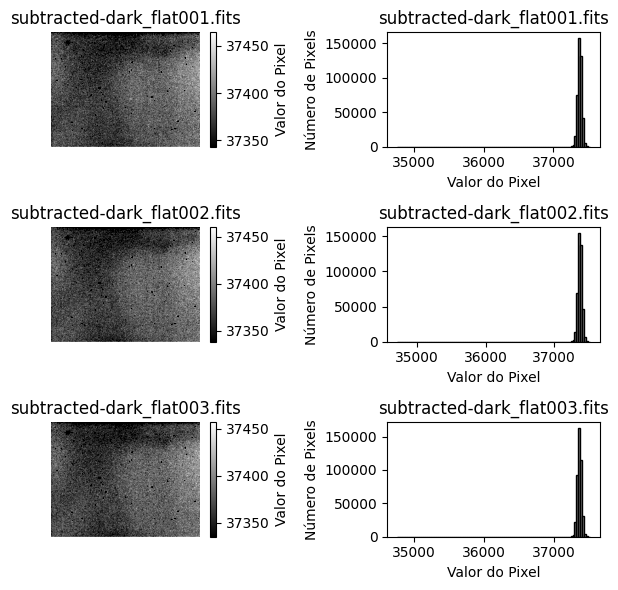

In [ ]:
#PLOTAR FLAT - MASTER_DARK

# Listar os caminhos dos arquivos FITS
file_paths = [
    '/home/astroesul/Downloads/matheus/treinoM104/subtracted-dark_flat001.fits',
    '/home/astroesul/Downloads/matheus/treinoM104/subtracted-dark_flat002.fits',
    '/home/astroesul/Downloads/matheus/treinoM104/subtracted-dark_flat003.fits'
]

# Configurar a figura para múltiplos subplots (imagem e histograma lado a lado)
num_files = len(file_paths)
fig, axes = plt.subplots(num_files, 2, figsize=(6, 2 * num_files))  # Ajuste de tamanho

# Loop através dos arquivos FITS
for i, file_path in enumerate(file_paths):
    # Ler os dados da imagem FITS
    with fits.open(file_path) as hdul:
        image_data = CCDData(hdul[0].data, meta=hdul[0].header, unit='adu').data
    
    # Definir os valores mínimo e máximo para o colormap
    vmin, vmax = np.percentile(image_data, (10, 99.8))  # Ajusta os percentis conforme necessário

    # Extrair apenas o nome do arquivo sem o caminho
    file_name = os.path.basename(file_path)
    
    # Plotar a imagem FITS
    ax_img = axes[i, 0]
    im = ax_img.imshow(image_data, cmap='gray', origin='lower', vmin=vmin, vmax=vmax)
    ax_img.set_title(file_name)  # Apenas o nome do arquivo
    ax_img.axis('off')
    cbar = plt.colorbar(im, ax=ax_img)
    cbar.set_label('Valor do Pixel')

    # Plotar o histograma
    ax_hist = axes[i, 1]
    ax_hist.hist(image_data.flatten(), bins=100, color='gray', edgecolor='black')
    ax_hist.set_title(file_name)  # Apenas o nome do arquivo
    ax_hist.set_xlabel('Valor do Pixel')
    ax_hist.set_ylabel('Número de Pixels')

# Ajustar o layout da figura
plt.tight_layout()
plt.show()

In [ ]:
#testar dimensão da imagem MASTER BIAS
from astropy.io import fits

# Caminho para o arquivo FITS de referência
master_bias = '/home/astroesul/Downloads/matheus/treinoM104/master_bias.fits'

# Abre o arquivo FITS de referência
with fits.open(master_bias) as bias_hdu:
    for i, hdu in enumerate(bias_hdu):
        print(f"Master Bias - Extension {i}: {hdu.name}")
        print(hdu.header)

Master Bias - Extension 0: PRIMARY
SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -64 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                  748                                                  NAXIS2  =                  577                                                  EXTEND  =                    T                                                  COMMENT   FITS (Flexible Image Transport System) format is defined in 'AstronomyCOMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H EXPOSURE=                 0.01 / Exposure time in seconds                       DATE    = '2023-02-20T01:28:20.924' / file creation time, UTC                   DATE-OBS= '2023-02-20T01:28:19.375' / Image capture start time, UTC             CREATOR = 'PHD2 Guiding 2.6.11' / Capture software                              PHDPR

In [ ]:
#testar dimensão das imagens FLAT - DARK

import os
from astropy.io import fits

# Lista de arquivos FITS
flat_subtracted_dark_files = [
    '/home/astroesul/Downloads/matheus/treinoM104/subtracted-dark_flat001.fits', 
    '/home/astroesul/Downloads/matheus/treinoM104/subtracted-dark_flat002.fits',
    '/home/astroesul/Downloads/matheus/treinoM104/subtracted-dark_flat003.fits'
]

# Itera sobre os arquivos e imprime suas extensões
for flat_file in flat_subtracted_dark_files:
    with fits.open(flat_file) as flat_hdu:
        for i, hdu in enumerate(flat_hdu):
            print(f"{os.path.basename(flat_file)} - Extension {i}: {hdu.name}")
            print(hdu.header)

subtracted-dark_flat001.fits - Extension 0: PRIMARY
SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -64 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                  748                                                  NAXIS2  =                  577                                                  EXTEND  =                    T                                                  EXPOSURE=                 0.01 / Exposure time in seconds                       DATE    = '2023-02-20T03:05:12.432' / file creation time, UTC                   DATE-OBS= '2023-02-20T03:05:10.911' / Image capture start time, UTC             CREATOR = 'PHD2 Guiding 2.6.11' / Capture software                              PHDPROFI= 'matheusastro'       / PHD2 Equipment Profile                         INSTRUME= 'Meade DSI'          / Instrument name                    

In [ ]:
#FAZER (FLAT - DARK) - BIAS

# Caminho para o arquivo FITS de referência
master_bias = '/home/astroesul/Downloads/matheus/treinoM104/master_bias.fits'

# Lista para armazenar os dados de imagem
flat_subtracted_dark_files = [
    '/home/astroesul/Downloads/matheus/treinoM104/subtracted-dark_flat001.fits', 
    '/home/astroesul/Downloads/matheus/treinoM104/subtracted-dark_flat002.fits',
    '/home/astroesul/Downloads/matheus/treinoM104/subtracted-dark_flat003.fits'
]

# Imprimindo os nomes dos arquivos
for flat_file in flat_subtracted_dark_files:
    filename = os.path.basename(flat_file)
    print(f"Filename: {filename}")

# Abre o arquivo de referência (master_bias.fits)
with fits.open(master_bias) as bias_hdu:
    bias_data = bias_hdu[2].data  # Supondo que os dados estão na extensão 2

# Diretório de saída
output_directory = '/home/astroesul/Downloads/matheus/treinoM104/'

# Itera sobre a lista de imagens flat e realiza a subtração
for flat_file in flat_subtracted_dark_files:
    # Abre o arquivo FITS flat
    with fits.open(flat_file) as flat_hdu:
        flat_data = flat_hdu[0].data  # Supondo que os dados estão na extensão 2
        
        # Verifica se os dados do arquivo de referência e o flat têm o mesmo formato
        if bias_data.shape != flat_data.shape:
            raise ValueError(f"Shape mismatch: bias shape {bias_data.shape} vs flat shape {flat_data.shape}")

        # Subtrai os dados do arquivo de referência dos dados do flat
        result_data = flat_data - bias_data

        # Cria um novo HDU com os dados resultantes
        result_hdu = fits.PrimaryHDU(result_data)
        result_header = flat_hdu[0].header  # Usando o cabeçalho do flat extensão 0
        result_hdu.header.update(result_header)  # Atualiza o cabeçalho com metadados originais

        # Define o nome do arquivo de saída
        output_filename = f"bias-{os.path.basename(flat_file)}"

        # Cria o caminho completo para o arquivo de saída
        output_path = os.path.join(output_directory, output_filename)

        # Salva o arquivo FITS resultante
        result_hdu.writeto(output_path, overwrite=True)

        print(f"Saved subtracted image to: {output_path}")

print("Subtraction completed for all flat images.")

Filename: subtracted-dark_flat001.fits
Filename: subtracted-dark_flat002.fits
Filename: subtracted-dark_flat003.fits
Saved subtracted image to: /home/meteoro/Documentos/treinoM104/bias-subtracted-dark_flat001.fits
Saved subtracted image to: /home/meteoro/Documentos/treinoM104/bias-subtracted-dark_flat002.fits
Saved subtracted image to: /home/meteoro/Documentos/treinoM104/bias-subtracted-dark_flat003.fits
Subtraction completed for all flat images.


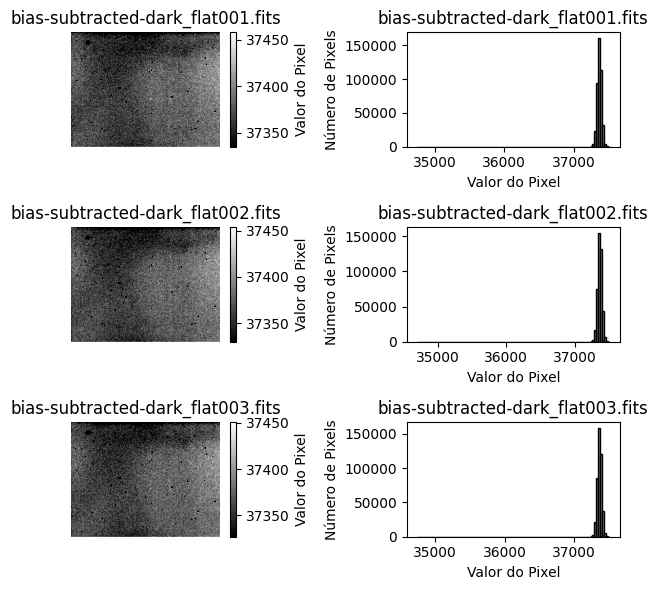

In [ ]:
#PLOTAR (FLAT - DARK) - BIAS

# Listar os caminhos dos arquivos FITS
file_paths = [
    '/home/astroesul/Downloads/matheus/treinoM104/bias-subtracted-dark_flat001.fits',
    '/home/astroesul/Downloads/matheus/treinoM104/bias-subtracted-dark_flat002.fits',
    '/home/astroesul/Downloads/matheus/treinoM104/bias-subtracted-dark_flat003.fits'
]

# Configurar a figura para múltiplos subplots (imagem e histograma lado a lado)
num_files = len(file_paths)
fig, axes = plt.subplots(num_files, 2, figsize=(6, 2 * num_files))  # Ajuste de tamanho

# Loop através dos arquivos FITS
for i, file_path in enumerate(file_paths):
    # Ler os dados da imagem FITS
    with fits.open(file_path) as hdul:
        image_data = CCDData(hdul[0].data, meta=hdul[0].header, unit='adu').data
    
    # Definir os valores mínimo e máximo para o colormap
    vmin, vmax = np.percentile(image_data, (10, 99.8))  # Ajusta os percentis conforme necessário

    # Extrair apenas o nome do arquivo sem o caminho
    file_name = os.path.basename(file_path)
    
    # Plotar a imagem FITS
    ax_img = axes[i, 0]
    im = ax_img.imshow(image_data, cmap='gray', origin='lower', vmin=vmin, vmax=vmax)
    ax_img.set_title(file_name)  # Apenas o nome do arquivo
    ax_img.axis('off')
    cbar = plt.colorbar(im, ax=ax_img)
    cbar.set_label('Valor do Pixel')

    # Plotar o histograma
    ax_hist = axes[i, 1]
    ax_hist.hist(image_data.flatten(), bins=100, color='gray', edgecolor='black')
    ax_hist.set_title(file_name)  # Apenas o nome do arquivo
    ax_hist.set_xlabel('Valor do Pixel')
    ax_hist.set_ylabel('Número de Pixels')

# Ajustar o layout da figura
plt.tight_layout()
plt.show()

In [ ]:
#MASTER FLAT
# Lista dos arquivos FITS com dados subtraídos
flat_subtracted_full_list = [
    '/home/astroesul/Downloads/matheus/treinoM104/bias-subtracted-dark_flat001.fits', 
    '/home/astroesul/Downloads/matheus/treinoM104/bias-subtracted-dark_flat002.fits',
    '/home/astroesul/Downloads/matheus/treinoM104/bias-subtracted-dark_flat003.fits'
]

# Função para calcular e normalizar pelo modo
def normalize_by_mode(ccd):
    mode = stats.mode(ccd.data, axis=None, keepdims=False)[0]
    return CCDData(ccd.data / mode, unit='adu', meta=ccd.meta)

# Carrega e normaliza as imagens FITS
ccd_list = [normalize_by_mode(CCDData.read(file, unit='adu')) for file in flat_subtracted_full_list]

# Combina as imagens normalizadas usando o método 'median' com sigma clipping
master_flat = ccdp.combine(
    ccd_list,
    method='median',
    sigma_clip=True,
    sigma_clip_low_thresh=5,
    sigma_clip_high_thresh=5,
    sigma_clip_func=np.ma.median,
    sigma_clip_dev_func=mad_std,
    mem_limit=350e6
)

# Adiciona uma nova chave ao cabeçalho para indicar que a combinação foi feita
master_flat.meta['combined'] = True

# Salva o arquivo FITS resultante
master_flat.write('/home/astroesul/Downloads/matheus/treinoM104/master_flat.fits', overwrite=True)

print("Master flat image saved successfully.")

Master flat image saved successfully.


In [ ]:
#VALOR MODAL DO MASTER_FLAT
from astropy.io import fits
import numpy as np

# Carrega a imagem FITS
fits_file = '/home/astroesul/Downloads/matheus/treinoM104/master_flat.fits'
with fits.open(fits_file) as hdul:
    data = hdul[0].data  # Ou ajuste conforme necessário

# Verifica se os dados são um array NumPy
data = np.asarray(data)

# Achata os dados para uma dimensão
flattened_data = data.flatten()

# Calcula o histograma dos dados
hist, bin_edges = np.histogram(flattened_data, bins=1000)  # Ajuste o número de bins conforme necessário

# Encontra o índice do bin com a maior contagem
mode_bin_index = np.argmax(hist)

# Calcula o valor modal como o centro do bin com a maior contagem
mode_value = (bin_edges[mode_bin_index] + bin_edges[mode_bin_index + 1]) / 2

print(f'Valor modal da imagem: {mode_value}')


Valor modal da imagem: 1.0014245159448498


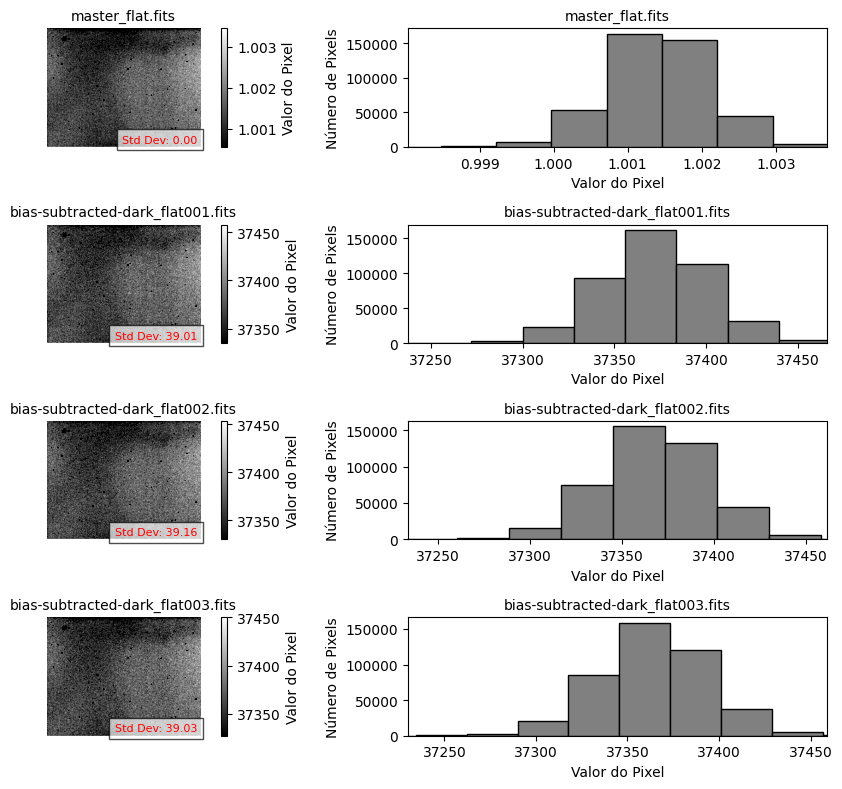

In [ ]:
#PLOTA FLATS
#PLOTA FLATS
# Caminhos dos arquivos FITS
file_paths = [
    '/home/astroesul/Downloads/matheus/treinoM104/master_flat.fits',
    '/home/astroesul/Downloads/matheus/treinoM104/bias-subtracted-dark_flat001.fits',
    '/home/astroesul/Downloads/matheus/treinoM104/bias-subtracted-dark_flat002.fits',
    '/home/astroesul/Downloads/matheus/treinoM104/bias-subtracted-dark_flat003.fits'
]

# Configurar a figura para múltiplos subplots (imagem e histograma lado a lado)
num_files = len(file_paths)
fig, axes = plt.subplots(num_files, 2, figsize=(10, 2 * num_files))  # Ajuste de tamanho

# Loop através dos arquivos FITS
for i, file_path in enumerate(file_paths):
    # Ler os dados da imagem FITS
    with fits.open(file_path) as hdul:
        image_data = CCDData(hdul[0].data, meta=hdul[0].header, unit='adu').data
    
    # Calcular o desvio padrão
    std_dev = np.std(image_data)
    
    # Definir os valores mínimo e máximo para o colormap
    vmin, vmax = np.percentile(image_data, (10, 99.8))  # Ajusta os percentis conforme necessário

    # Extrair apenas o nome do arquivo sem o caminho
    file_name = os.path.basename(file_path)
    
    # Plotar a imagem FITS
    ax_img = axes[i, 0]
    im = ax_img.imshow(image_data, cmap='gray', origin='lower', vmin=vmin, vmax=vmax)
    ax_img.set_title(file_name, fontsize=10)  # Nome do arquivo em fonte menor
    ax_img.axis('off')
    cbar = plt.colorbar(im, ax=ax_img)
    cbar.set_label('Valor do Pixel')

    # Adicionar o desvio padrão como anotação na imagem
    ax_img.text(0.98, 0.02, f'Std Dev: {std_dev:.2f}', color='red', 
                fontsize=8, ha='right', va='bottom', 
                transform=ax_img.transAxes, bbox=dict(facecolor='white', alpha=0.7))

    # Plotar o histograma
    ax_hist = axes[i, 1]
    pixel_values = image_data.flatten()
    
    # Calcular os limites dos dados para o histograma
    min_val = np.percentile(pixel_values, 0.1)  # Excluir valores extremos muito baixos
    max_val = np.percentile(pixel_values, 99.9)  # Excluir valores extremos muito altos

    
    # Ajustar os limites do histograma para mostrar apenas a área com dados
    ax_hist.hist(pixel_values, bins=100, color='gray', edgecolor='black')
    ax_hist.set_xlim(min_val, max_val)  # Limita os eixos x ao intervalo de dados
    ax_hist.set_title(file_name, fontsize=10)  # Nome do arquivo em fonte menor
    ax_hist.set_xlabel('Valor do Pixel')
    ax_hist.set_ylabel('Número de Pixels')

# Ajustar o layout da figura
plt.tight_layout()
plt.show()

In [ ]:
light_list = []

# Itera sobre os arquivos encontrados
for fname in image_files:
    with fits.open(fname) as hdulist:
        # Itera sobre todas as extensões no arquivo FITS
        for hdu in hdulist:
            # Verifica se o tipo de imagem é 'light'
            if 'light' in hdu.header.get('IMAGETYP', '').lower():
                # Cria um dicionário para os metadados
                meta = hdu.header.copy()  # Copia o cabeçalho para os metadados
                meta['filename'] = fname  # Adiciona o nome do arquivo aos metadados
                
                # Cria um objeto CCDData e adiciona à lista
                light_list.append(CCDData(data=hdu.data, meta=meta, unit="adu"))

for light in light_list:
    print(f"Filename: {light.meta['filename']}")

Filename: /home/meteoro/Documentos/treinoM104/light111.fits
Filename: /home/meteoro/Documentos/treinoM104/light22.fits


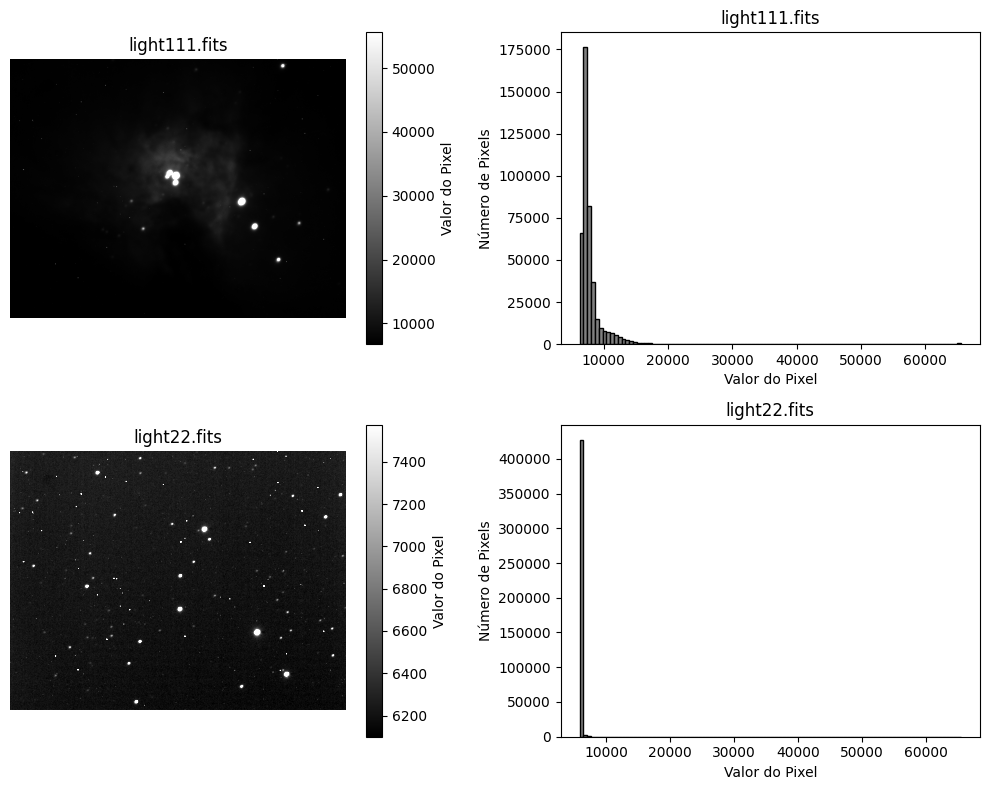

In [ ]:
#PLOTA ARQUIVOS LIGHT
# Listar os caminhos dos arquivos FITS
file_paths = [
    '/home/astroesul/Downloads/matheus/treinoM104/light111.fits',
    '/home/astroesul/Downloads/matheus/treinoM104/light22.fits'
]

# Configurar a figura para múltiplos subplots (imagem e histograma lado a lado)
num_files = len(file_paths)
fig, axes = plt.subplots(num_files, 2, figsize=(10, 4 * num_files))  # Ajuste de tamanho

# Loop através dos arquivos FITS
for i, file_path in enumerate(file_paths):
    # Ler os dados da imagem FITS
    with fits.open(file_path) as hdul:
        image_data = CCDData(hdul[0].data, meta=hdul[0].header, unit='adu').data
    
    # Definir os valores mínimo e máximo para o colormap
    vmin, vmax = np.percentile(image_data, (10, 99.8))  # Ajusta os percentis conforme necessário

    # Extrair apenas o nome do arquivo sem o caminho
    file_name = os.path.basename(file_path)
    
    # Plotar a imagem FITS
    ax_img = axes[i, 0]
    im = ax_img.imshow(image_data, cmap='gray', origin='lower', vmin=vmin, vmax=vmax)
    ax_img.set_title(file_name)  # Apenas o nome do arquivo
    ax_img.axis('off')
    cbar = plt.colorbar(im, ax=ax_img)
    cbar.set_label('Valor do Pixel')


    # Plotar o histograma
    ax_hist = axes[i, 1]
    ax_hist.hist(image_data.flatten(), bins=100, color='gray', edgecolor='black')
    ax_hist.set_title(file_name)  # Apenas o nome do arquivo
    ax_hist.set_xlabel('Valor do Pixel')
    ax_hist.set_ylabel('Número de Pixels')

# Ajustar o layout da figura
plt.tight_layout()
plt.show()

In [ ]:
#testar dimensão da imagem MASTER DARK 
from astropy.io import fits

# Caminho para o arquivo FITS de referência
master_bias = '/home/astroesul/Downloads/matheus/treinoM104/master_dark.fits'

# Abre o arquivo FITS de referência
with fits.open(master_bias) as bias_hdu:
    for i, hdu in enumerate(bias_hdu):
        print(f"Master Bias - Extension {i}: {hdu.name}")
        print(hdu.header)

Master Bias - Extension 0: PRIMARY
SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -64 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                  748                                                  NAXIS2  =                  577                                                  EXTEND  =                    T                                                  COMMENT   FITS (Flexible Image Transport System) format is defined in 'AstronomyCOMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H EXPOSURE=                  15. / Exposure time in seconds                       DATE    = '2023-02-20T01:31:07.535' / file creation time, UTC                   DATE-OBS= '2023-02-20T01:30:44.203' / Image capture start time, UTC             CREATOR = 'PHD2 Guiding 2.6.11' / Capture software                              PHDPR

In [ ]:
#TESTA DIMENSOES DOS LIGHTS
light_list = []

# Itera sobre os arquivos encontrados
for fname in image_files:
    with fits.open(fname) as hdulist:
        # Itera sobre todas as extensões no arquivo FITS
        for hdu in hdulist:
            # Verifica se o tipo de imagem é 'light'
            if 'light' in hdu.header.get('IMAGETYP', '').lower():
                # Cria um dicionário para os metadados
                meta = hdu.header.copy()  # Copia o cabeçalho para os metadados
                meta['filename'] = fname  # Adiciona o nome do arquivo aos metadados
                
                # Cria um objeto CCDData e adiciona à lista
                light_list.append(CCDData(data=hdu.data, meta=meta, unit="adu"))

# Itera sobre a lista de dados 'light'
for i, ccd_data in enumerate(light_list):
    # Imprime o nome do arquivo

    print(f"LIGHT FRAMES{i}: {hdu.name}")
    print(hdu.header)

LIGHT FRAMES0: PRIMARY
SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -32 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                  748                                                  NAXIS2  =                  577                                                  COMMENT   FITS (Flexible Image Transport System) format is defined in 'AstronomyCOMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H EXPTIME =                   4. / Total Exposure Time                            SNAPSHOT=                    1 / Number of stacked images                       FOCALLEN=                  800 / Focal Length                                   OBSERVER= 'Not specified'      / Observer Name                                  APTDIA  =                 2032 / Aperture Diameter in mm                        TELESCOP= 'Not sp

In [ ]:
# fazer LIGHT - DARK

# Caminho para o arquivo FITS de referência
dark_file = '/home/astroesul/Downloads/matheus/treinoM104/master_dark.fits'

# Lista para armazenar os dados de imagem
light_list = []

# Itera sobre os arquivos encontrados
for fname in image_files:
    with fits.open(fname) as hdulist:
        # Itera sobre todas as extensões no arquivo FITS
        for hdu in hdulist:
            # Verifica se o tipo de imagem é 'light'
            if 'light' in hdu.header.get('IMAGETYP', '').lower():
                # Cria um dicionário para os metadados
                meta = hdu.header.copy()  # Copia o cabeçalho para os metadados
                meta['filename'] = fname  # Adiciona o nome do arquivo aos metadados
                
                # Cria um objeto CCDData e adiciona à lista
                light_list.append(CCDData(data=hdu.data, meta=meta, unit="adu"))

# Exibe a lista de arquivos light encontrados
for light in light_list:
    print(f"Filename: {light.meta['filename']}")

# Abre o arquivo de referência (combined_dark.fits)
with fits.open(dark_file) as dark_hdu:
    dark_data = dark_hdu[2].data  # Supondo que os dados estão na extensão 1

# Diretório de saída
output_directory = '/home/astroesul/Downloads/matheus/treinoM104/'

# Itera sobre a lista de imagens light e realiza a subtração
for light in light_list:
    # Verifica se os dados do arquivo de referência e o light têm o mesmo formato
    if dark_data.shape != light.data.shape:
        raise ValueError(f"Shape mismatch: dark file shape {dark_data.shape} vs light file shape {light.data.shape}")

    # Subtrai os dados do arquivo de referência dos dados do light
    result_data = light.data - dark_data

    # Cria um novo HDU com os dados resultantes
    result_hdu = fits.PrimaryHDU(result_data)
    result_header = light.meta
    result_hdu.header.update(result_header)  # Atualiza o cabeçalho com metadados originais

    # Define o nome do arquivo de saída
    output_filename = f"subtracted-dark_{os.path.basename(light.meta['filename'])}"

    # Cria o caminho completo para o arquivo de saída
    output_path = os.path.join(output_directory, output_filename)

    # Salva o arquivo FITS resultante
    result_hdu.writeto(output_path, overwrite=True)

    print(f"Saved subtracted image to: {output_path}")

print("Subtraction completed for all light images.")

Filename: /home/meteoro/Documentos/treinoM104/light111.fits
Filename: /home/meteoro/Documentos/treinoM104/light22.fits
Saved subtracted image to: /home/meteoro/Documentos/treinoM104/subtracted-dark_light111.fits
Saved subtracted image to: /home/meteoro/Documentos/treinoM104/subtracted-dark_light22.fits
Subtraction completed for all light images.


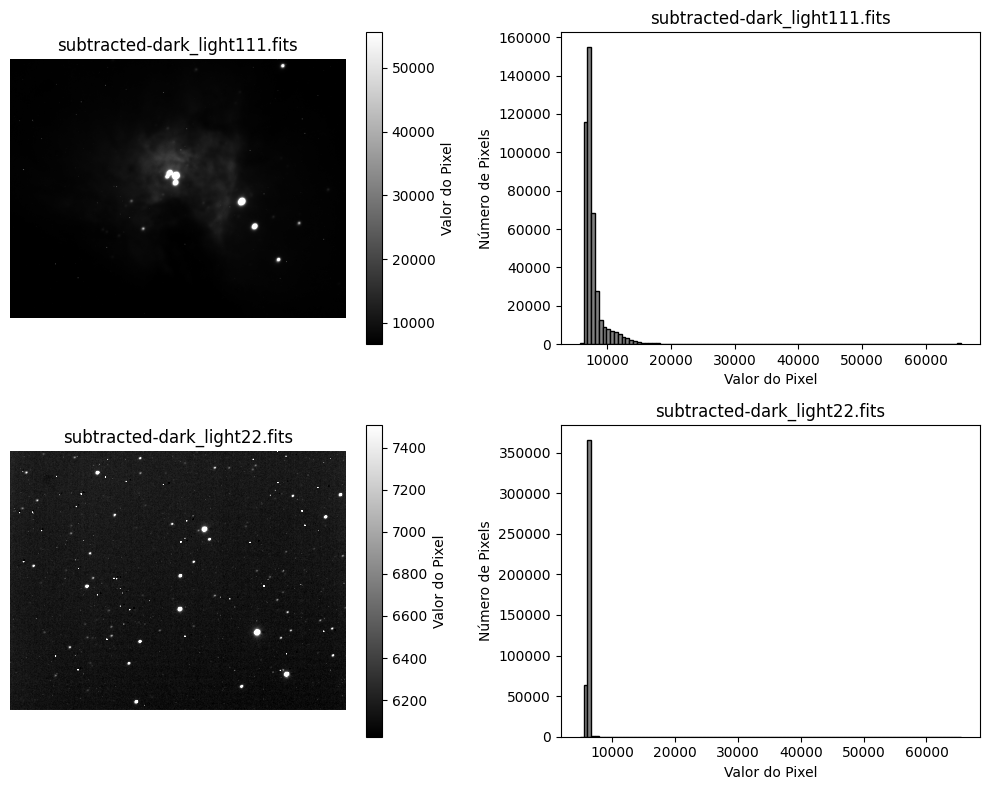

In [ ]:
#PLOTAR LIGHT - DARK

# Listar os caminhos dos arquivos FITS
file_paths = [
    '/home/astroesul/Downloads/matheus/treinoM104/subtracted-dark_light111.fits',
    '/home/astroesul/Downloads/matheus/treinoM104/subtracted-dark_light22.fits'
]

# Configurar a figura para múltiplos subplots (imagem e histograma lado a lado)
num_files = len(file_paths)
fig, axes = plt.subplots(num_files, 2, figsize=(10, 4 * num_files))  # Ajuste de tamanho

# Loop através dos arquivos FITS
for i, file_path in enumerate(file_paths):
    # Ler os dados da imagem FITS
    with fits.open(file_path) as hdul:
        image_data = CCDData(hdul[0].data, meta=hdul[0].header, unit='adu').data
    
    # Definir os valores mínimo e máximo para o colormap
    vmin, vmax = np.percentile(image_data, (10, 99.8))  # Ajusta os percentis conforme necessário

    # Extrair apenas o nome do arquivo sem o caminho
    file_name = os.path.basename(file_path)
    
    # Plotar a imagem FITS
    ax_img = axes[i, 0]
    im = ax_img.imshow(image_data, cmap='gray', origin='lower', vmin=vmin, vmax=vmax)
    ax_img.set_title(file_name)  # Apenas o nome do arquivo
    ax_img.axis('off')
    cbar = plt.colorbar(im, ax=ax_img)
    cbar.set_label('Valor do Pixel')

    # Plotar o histograma
    ax_hist = axes[i, 1]
    ax_hist.hist(image_data.flatten(), bins=100, color='gray', edgecolor='black')
    ax_hist.set_title(file_name)  # Apenas o nome do arquivo
    ax_hist.set_xlabel('Valor do Pixel')
    ax_hist.set_ylabel('Número de Pixels')

# Ajustar o layout da figura
plt.tight_layout()
plt.show()

In [ ]:
# FAZER (LIGHT - DARK ) - BIAS

# Caminho para o arquivo FITS de referência
master_bias = '/home/astroesul/Downloads/matheus/treinoM104/master_bias.fits'

# Lista para armazenar os arquivos subtraídos do dark
light_subtracted_dark_files = [
    '/home/astroesul/Downloads/matheus/treinoM104/subtracted-dark_light111.fits', 
    '/home/astroesul/Downloads/matheus/treinoM104/subtracted-dark_light22.fits',
]

# Imprimindo os nomes dos arquivos
for light_file in light_subtracted_dark_files:
    filename = os.path.basename(light_file)
    print(f"Filename: {filename}")

# Abre o arquivo de referência (master_bias.fits)
with fits.open(master_bias) as bias_hdu:
    bias_data = bias_hdu[2].data  # Supondo que os dados estão na extensão 0

# Diretório de saída
output_directory = '/home/astroesul/Downloads/matheus/treinoM104/'

# Itera sobre a lista de imagens light e realiza a subtração
for light_file in light_subtracted_dark_files:
    # Abre o arquivo FITS light subtraído do dark
    with fits.open(light_file) as light_hdu:
        light_data = light_hdu[0].data  # Supondo que os dados estão na extensão 0
        
        # Verifica se os dados do arquivo de referência e o light têm o mesmo formato
        if bias_data.shape != light_data.shape:
            raise ValueError(f"Shape mismatch: bias shape {bias_data.shape} vs light shape {light_data.shape}")

        # Subtrai os dados do arquivo de referência dos dados do light
        result_data = light_data - bias_data

        # Cria um novo HDU com os dados resultantes
        result_hdu = fits.PrimaryHDU(result_data)
        result_header = light_hdu[0].header  # Usando o cabeçalho do light
        result_hdu.header.update(result_header)  # Atualiza o cabeçalho com metadados originais

        # Define o nome do arquivo de saída
        output_filename = f"bias-{os.path.basename(light_file)}"

        # Cria o caminho completo para o arquivo de saída
        output_path = os.path.join(output_directory, output_filename)

        # Salva o arquivo FITS resultante
        result_hdu.writeto(output_path, overwrite=True)

        print(f"Saved subtracted image to: {output_path}")

print("Subtraction completed for all light images.")

Filename: subtracted-dark_light111.fits
Filename: subtracted-dark_light22.fits
Saved subtracted image to: /home/meteoro/Documentos/treinoM104/bias-subtracted-dark_light111.fits
Saved subtracted image to: /home/meteoro/Documentos/treinoM104/bias-subtracted-dark_light22.fits
Subtraction completed for all light images.


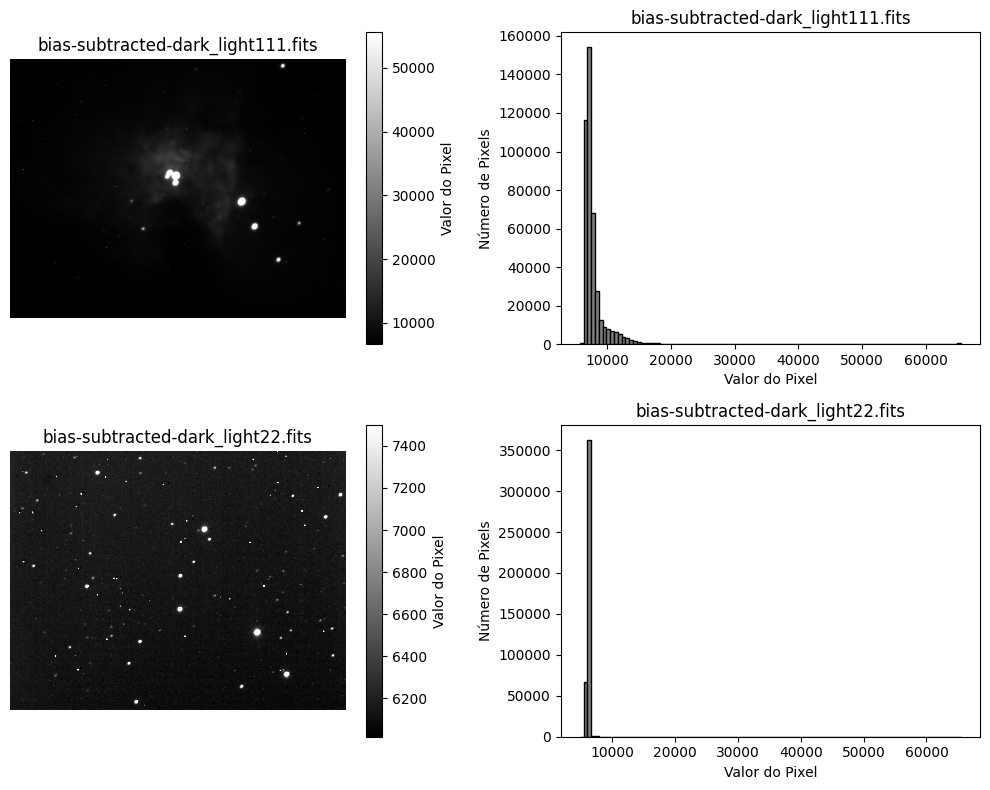

In [ ]:
#PLOTAR (LIGHT - DARK ) - BIAS


file_paths = [
    '/home/astroesul/Downloads/matheus/treinoM104/bias-subtracted-dark_light111.fits',
    '/home/astroesul/Downloads/matheus/treinoM104/bias-subtracted-dark_light22.fits'
]

# Configurar a figura para múltiplos subplots (imagem e histograma lado a lado)
num_files = len(file_paths)
fig, axes = plt.subplots(num_files, 2, figsize=(10, 4 * num_files))  # Ajuste de tamanho

# Loop através dos arquivos FITS
for i, file_path in enumerate(file_paths):
    # Ler os dados da imagem FITS
    with fits.open(file_path) as hdul:
        image_data = CCDData(hdul[0].data, meta=hdul[0].header, unit='adu').data
    
    # Definir os valores mínimo e máximo para o colormap
    vmin, vmax = np.percentile(image_data, (10, 99.8))  # Ajusta os percentis conforme necessário

    # Extrair apenas o nome do arquivo sem o caminho
    file_name = os.path.basename(file_path)
    
    # Plotar a imagem FITS
    ax_img = axes[i, 0]
    im = ax_img.imshow(image_data, cmap='gray', origin='lower', vmin=vmin, vmax=vmax)
    ax_img.set_title(file_name)  # Apenas o nome do arquivo
    ax_img.axis('off')
    cbar = plt.colorbar(im, ax=ax_img)
    cbar.set_label('Valor do Pixel')

    # Plotar o histograma
    ax_hist = axes[i, 1]
    ax_hist.hist(image_data.flatten(), bins=100, color='gray', edgecolor='black')
    ax_hist.set_title(file_name)  # Apenas o nome do arquivo
    ax_hist.set_xlabel('Valor do Pixel')
    ax_hist.set_ylabel('Número de Pixels')

# Ajustar o layout da figura
plt.tight_layout()
plt.show()

In [ ]:
#testar dimensão do MASTER FLAT

import os
from astropy.io import fits

# Lista de arquivos FITS
flat_subtracted_dark_files = [
    '/home/astroesul/Downloads/matheus/treinoM104/master_flat.fits'
]

# Itera sobre os arquivos e imprime suas extensões
for flat_file in flat_subtracted_dark_files:
    with fits.open(flat_file) as flat_hdu:
        for i, hdu in enumerate(flat_hdu):
            print(f"{os.path.basename(flat_file)} - Extension {i}: {hdu.name}")
            print(hdu.header)

master_flat.fits - Extension 0: PRIMARY
SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -64 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                  748                                                  NAXIS2  =                  577                                                  EXTEND  =                    T                                                  EXPOSURE=                 0.01 / Exposure time in seconds                       DATE    = '2023-02-20T03:05:12.432' / file creation time, UTC                   DATE-OBS= '2023-02-20T03:05:10.911' / Image capture start time, UTC             CREATOR = 'PHD2 Guiding 2.6.11' / Capture software                              PHDPROFI= 'matheusastro'       / PHD2 Equipment Profile                         INSTRUME= 'Meade DSI'          / Instrument name                                

Filename: /home/meteoro/Documentos/treinoM104/bias-subtracted-dark_light22.fits
Filename: /home/meteoro/Documentos/treinoM104/bias-subtracted-dark_light111.fits
Saved divided image to: /home/meteoro/Documentos/treinoM104/flat-divided-bias-subtracted-dark_light22.fits


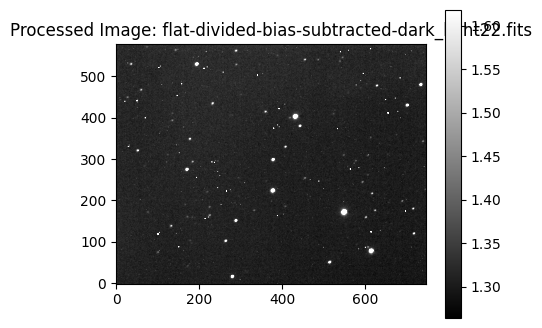

Saved divided image to: /home/meteoro/Documentos/treinoM104/flat-divided-bias-subtracted-dark_light111.fits


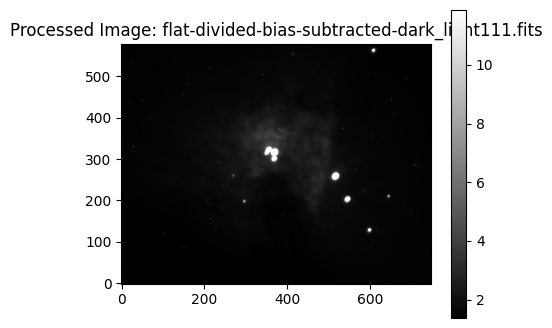

Division completed for all light images.


In [ ]:
#LIGHT / FLAT NORM

# Lista de arquivos light
light_files = [
    '/home/astroesul/Downloads/matheus/treinoM104/bias-subtracted-dark_light22.fits',
    '/home/astroesul/Downloads/matheus/treinoM104/bias-subtracted-dark_light111.fits'
]

# Caminho para o arquivo FITS de referência
flat_file = '/home/astroesul/Downloads/matheus/treinoM104/master_flat.fits'

# Lista para armazenar CCDData
ccd_list = []

# Itera sobre os arquivos light fornecidos
for fname in light_files:
    with fits.open(fname) as hdulist:
        # Itera sobre todas as extensões no arquivo FITS
        for hdu in hdulist:
            # Verifica se o tipo de imagem é 'light'
            if 'light' in hdu.header.get('IMAGETYP', '').lower():
                # Cria um dicionário para os metadados
                meta = hdu.header.copy()  # Copia o cabeçalho para os metadados
                meta['filename'] = fname  # Adiciona o nome do arquivo aos metadados
                
                # Cria um objeto CCDData e adiciona à lista
                ccd_list.append(CCDData(data=hdu.data, meta=meta, unit="adu"))

# Exibe a lista de arquivos light encontrados
for light in ccd_list:
    print(f"Filename: {light.meta['filename']}")

# Abre o arquivo de referência (master_flat.fits)
with fits.open(flat_file) as flat_hdu:
    flat_data = flat_hdu[1].data  # Supondo que os dados estão na extensão principal

# Diretório de saída
output_directory = '/home/astroesul/Downloads/matheus/treinoM104/'

# Itera sobre a lista de imagens light e realiza a divisão
for light in ccd_list:
    # Verifica se os dados do arquivo de referência e o light têm o mesmo formato
    if flat_data.shape != light.data.shape:
        raise ValueError(f"Shape mismatch: flat file shape {flat_data.shape} vs light file shape {light.data.shape}")

    # Divide os dados do light pelos dados do flat
    result_data = light.data / flat.data

    # Cria um novo HDU com os dados resultantes
    result_hdu = fits.PrimaryHDU(result_data)
    result_header = light.meta
    result_hdu.header.update(result_header)  # Atualiza o cabeçalho com metadados originais

    # Define o nome do arquivo de saída
    output_filename = f"flat-divided-{os.path.basename(light.meta['filename'])}"

    # Cria o caminho completo para o arquivo de saída
    output_path = os.path.join(output_directory, output_filename)

    # Salva o arquivo FITS resultante
    result_hdu.writeto(output_path, overwrite=True)

    print(f"Saved divided image to: {output_path}")

    # Plotagem da imagem resultante
    plt.figure(figsize=(5, 4))
    plt.imshow(result_data, cmap='gray', origin='lower', vmin=np.percentile(result_data, 1), vmax=np.percentile(result_data, 99.8))
    plt.colorbar()
    plt.title(f"Processed Image: {os.path.basename(output_path)}")
    plt.show()

print("Division completed for all light images.")

In [ ]:
#PEGA AS COORDENADAS DAS ESTRELAS

from astropy.io import fits
from astropy.stats import mad_std
from astropy.table import Table
from photutils import DAOStarFinder
from scipy.spatial import cKDTree
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import os

def process_image(fits_file, fwhm=9.0, threshold_factor=20.0):
    with fits.open(fits_file) as hdulist:
        image_data = hdulist[0].data
    
    # Ajuste do limiar com base na mediana e desvio padrão dos dados
    threshold = threshold_factor * mad_std(image_data)
    daofind = DAOStarFinder(fwhm=fwhm, threshold=threshold)
    sources = daofind(image_data)
    if sources is not None:
        stars_table = Table(sources)
    else:
        stars_table = Table(names=('xcentroid', 'ycentroid', 'peak', 'flux'), dtype=('f8', 'f8', 'f8', 'f8'))
    return image_data, stars_table

def draw_circles(ax, stars_table, fwhm):
    for star in stars_table:
        circle = Circle((star['xcentroid'], star['ycentroid']), fwhm/2, edgecolor='red', facecolor='none', linewidth=1.5)
        ax.add_patch(circle)
        ax.text(star['xcentroid'], star['ycentroid'], f"({star['xcentroid']:.1f}, {star['ycentroid']:.1f})", color='yellow', fontsize=10, ha='center')

def save_stars_table_to_txt(stars_table, fits_file):
    # Obtém o diretório do arquivo FITS e cria o nome do arquivo .txt
    dir_name = os.path.dirname(fits_file)
    base_name = os.path.basename(fits_file).replace('.fits', '_stars.txt')
    txt_file = os.path.join(dir_name, base_name)

    with open(txt_file, 'w') as f:
        f.write('xcentroid\tycentroid\tpeak\tflux\n')
        for star in stars_table:
            f.write(f"{star['xcentroid']:.2f}\t{star['ycentroid']:.2f}\t{star['peak']:.2f}\t{star['flux']:.2f}\n")

    return txt_file

# Caminho para os arquivos FITS
fits_file1 = '/home/astroesul/Downloads/matheus/treinoM104/flat-divided-bias-subtracted-dark_light111.fits'
fits_file2 = '/home/astroesul/Downloads/matheus/treinoM104/flat-divided-bias-subtracted-dark_light22.fits'

# Processa as imagens para detectar estrelas
image_data_1, stars_table_1 = process_image(fits_file1)
image_data_2, stars_table_2 = process_image(fits_file2)

# Salva as tabelas de estrelas em arquivos .txt
txt_file1 = save_stars_table_to_txt(stars_table_1, fits_file1)
txt_file2 = save_stars_table_to_txt(stars_table_2, fits_file2)

print(f"Informações salvas em: {txt_file1}")
print(f"Informações salvas em: {txt_file2}")

# Configurações de visualização
fig, axs = plt.subplots(1, 2, figsize=(16, 6), sharex=True, sharey=True)

# Define vmin e vmax para a visualização
vmin_1, vmax_1 = np.percentile(image_data_1, (10, 99.8))
vmin_2, vmax_2 = np.percentile(image_data_2, (10, 99.8))

axs[0].imshow(image_data_1, cmap='gray', origin='lower', vmin=vmin_1, vmax=vmax_1)
draw_circles(axs[0], stars_table_1, fwhm=3.0)
axs[0].set_title(f"{os.path.basename(fits_file1)}", fontsize=14)
axs[0].set_xlabel('Pixel X', fontsize=12)
axs[0].set_ylabel('Pixel Y', fontsize=12)
axs[0].tick_params(axis='both', which='major', labelsize=10)
axs[0].axis('on')

# Plota a imagem 2 e suas coordenadas
axs[1].imshow(image_data_2, cmap='gray', origin='lower', vmin=vmin_2, vmax=vmax_2)
draw_circles(axs[1], stars_table_2, fwhm=3.0)
axs[1].set_title(f"{os.path.basename(fits_file2)}", fontsize=14)
axs[1].set_xlabel('Pixel X', fontsize=12)
axs[1].tick_params(axis='both', which='major', labelsize=10)
axs[1].axis('on')

plt.show()

ModuleNotFoundError: No module named 'photutils'

In [ ]:
#fazer shift

import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy.ndimage import shift, rotate
import os

# Caminho para o arquivo FITS original
fits_file = '/home/astroesul/Downloads/matheus/treinoM104/flat-divided-bias-subtracted-dark_light22.fits'

# Caminho para o novo arquivo FITS
shifted_fits_file = '/home/astroesul/Downloads/matheus/treinoM104/shifted_flat-divided-bias-subtracted-dark_light22.fits'

# Parâmetros de shift e rotação
x_shift = 2
y_shift = 9
rotation_angle = -0.2  # Exemplo: 15 graus

# Função para desenhar círculos (placeholder)
def draw_circles(ax, stars_table, fwhm=3.0):
    # Implementar a função se necessário
    pass

# Carregar o arquivo FITS
with fits.open(fits_file) as hdul:
    # Acessar a primeira extensão (imagens geralmente estão na primeira extensão)
    image_data = hdul[0].data

    # Calcular a média da imagem
    mean_value = np.mean(image_data)

    # Verificar o formato dos dados
    print(f"Dimensões da imagem original: {image_data.shape}")
    print(f"Média da imagem original: {mean_value}")

    # Aplicar rotação
    rotated_data = rotate(image_data, angle=rotation_angle, reshape=True, mode='nearest')

    # Aplicar shift
    shifted_data = shift(rotated_data, shift=[y_shift, x_shift], mode='nearest')

    # Verificar as dimensões da imagem shiftada
    print(f"Dimensões da imagem shiftada: {shifted_data.shape}")

    # Atualizar o header
    header = hdul[0].header.copy()

    # Ajustar o header para novas dimensões se necessário
    header['NAXIS1'] = shifted_data.shape[1]
    header['NAXIS2'] = shifted_data.shape[0]

# Criar novo arquivo FITS com a imagem shiftada
hdu = fits.PrimaryHDU(shifted_data, header=header)
hdul_new = fits.HDUList([hdu])
hdul_new.writeto(shifted_fits_file, overwrite=True)

print(f"Imagem shiftada salva em: {shifted_fits_file}")

# Configurações de visualização
fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharex=True, sharey=True)

# Ajuste o intervalo de visualização para imagens saturadas
vmin_1, vmax_1 = np.percentile(image_data, (1, 99.8))
vmin_2, vmax_2 = np.percentile(shifted_data, (1, 99.8))

# Plotar imagem original
img1 = axs[0].imshow(image_data, cmap='gray', origin='lower', vmin=vmin_1, vmax=vmax_1)
# draw_circles(axs[0], stars_table_1, fwhm=3.0)  # Se você tiver dados para desenhar círculos
axs[0].set_title(f"Imagem Original\n{os.path.basename(fits_file)}", fontsize=14)
axs[0].set_xlabel('Pixel X', fontsize=12)
axs[0].set_ylabel('Pixel Y', fontsize=12)
axs[0].tick_params(axis='both', which='major', labelsize=10)
axs[0].axis('on')

# Adicionar barra de cores para a imagem original
cbar1 = plt.colorbar(img1, ax=axs[0])
cbar1.set_label('Intensidade', fontsize=12)

# Plotar imagem shiftada
img2 = axs[1].imshow(shifted_data, cmap='gray', origin='lower', vmin=vmin_2, vmax=vmax_2)
# draw_circles(axs[1], stars_table_2, fwhm=3.0)  # Se você tiver dados para desenhar círculos
axs[1].set_title(f"Imagem Shiftada\n{os.path.basename(shifted_fits_file)}", fontsize=14)
axs[1].set_xlabel('Pixel X', fontsize=12)
axs[1].tick_params(axis='both', which='major', labelsize=10)
axs[1].axis('on')

# Adicionar barra de cores para a imagem shiftada
cbar2 = plt.colorbar(img2, ax=axs[1])
cbar2.set_label('Intensidade', fontsize=12)

plt.tight_layout()
plt.show()

: 

In [ ]:
#PEGA AS COORDENADAS DAS ESTRELAS

from astropy.io import fits
from astropy.stats import mad_std
from astropy.table import Table
from photutils import DAOStarFinder
from scipy.spatial import cKDTree
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import os

def process_image(fits_file, fwhm=3.0, threshold_factor=20.0):
    with fits.open(fits_file) as hdulist:
        image_data = hdulist[0].data
    
    # Ajuste do limiar com base na mediana e desvio padrão dos dados
    threshold = threshold_factor * mad_std(image_data)
    daofind = DAOStarFinder(fwhm=fwhm, threshold=threshold)
    sources = daofind(image_data)
    if sources is not None:
        stars_table = Table(sources)
    else:
        stars_table = Table(names=('xcentroid', 'ycentroid', 'peak', 'flux'), dtype=('f8', 'f8', 'f8', 'f8'))
    return image_data, stars_table

def draw_circles(ax, stars_table, fwhm):
    for star in stars_table:
        circle = Circle((star['xcentroid'], star['ycentroid']), fwhm/2, edgecolor='red', facecolor='none', linewidth=1.5)
        ax.add_patch(circle)
        ax.text(star['xcentroid'], star['ycentroid'], f"({star['xcentroid']:.1f}, {star['ycentroid']:.1f})", color='yellow', fontsize=10, ha='center')

def save_stars_table_to_txt(stars_table, fits_file):
    # Obtém o diretório do arquivo FITS e cria o nome do arquivo .txt
    dir_name = os.path.dirname(fits_file)
    base_name = os.path.basename(fits_file).replace('.fits', '_stars.txt')
    txt_file = os.path.join(dir_name, base_name)

    with open(txt_file, 'w') as f:
        f.write('xcentroid\tycentroid\tpeak\tflux\n')
        for star in stars_table:
            f.write(f"{star['xcentroid']:.2f}\t{star['ycentroid']:.2f}\t{star['peak']:.2f}\t{star['flux']:.2f}\n")

    return txt_file

# Caminho para os arquivos FITS
fits_file1 = '/home/astroesul/Downloads/matheus/treinoM104/flat-divided-bias-subtracted-dark_light111.fits'
fits_file2 = '/home/astroesul/Downloads/matheus/treinoM104/shifted_flat-divided-bias-subtracted-dark_light22.fits'

# Processa as imagens para detectar estrelas
image_data_1, stars_table_1 = process_image(fits_file1)
image_data_2, stars_table_2 = process_image(fits_file2)

# Salva as tabelas de estrelas em arquivos .txt
txt_file1 = save_stars_table_to_txt(stars_table_1, fits_file1)
txt_file2 = save_stars_table_to_txt(stars_table_2, fits_file2)

print(f"Informações salvas em: {txt_file1}")
print(f"Informações salvas em: {txt_file2}")

# Configurações de visualização
fig, axs = plt.subplots(1, 2, figsize=(16, 6), sharex=True, sharey=True)


axs[0].imshow(image_data_1, cmap='gray', origin='lower', vmin=vmin_1, vmax=vmax_1)
draw_circles(axs[0], stars_table_1, fwhm=3.0)
axs[0].set_title(f"{os.path.basename(fits_file1)}", fontsize=14)
axs[0].set_xlabel('Pixel X', fontsize=12)
axs[0].set_ylabel('Pixel Y', fontsize=12)
axs[0].tick_params(axis='both', which='major', labelsize=10)
axs[0].axis('on')

# Plota a imagem 2 e suas coordenadas
axs[1].imshow(image_data_2, cmap='gray', origin='lower', vmin=vmin_2, vmax=vmax_2)
draw_circles(axs[1], stars_table_2, fwhm=3.0)
axs[1].set_title(f"{os.path.basename(fits_file2)}", fontsize=14)
axs[1].set_xlabel('Pixel X', fontsize=12)
axs[1].tick_params(axis='both', which='major', labelsize=10)
axs[1].axis('on')

plt.show()

: 

In [ ]:
#SHIFTAR SEGUNDA IMAGEM NOVAMENTE

import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy.ndimage import shift, rotate
import os

# Caminho para o arquivo FITS original
fits_file = '/home/astroesul/Downloads/matheus/treinoM104/shifted_flat-divided-bias-subtracted-dark_light22.fits'

# Caminho para o novo arquivo FITS
shifted_fits_file = '/home/astroesul/Downloads/matheus/treinoM104/shifted2_flat-divided-bias-subtracted-dark_light22.fits'

# Parâmetros de shift e rotação
x_shift = 0
y_shift = 0
rotation_angle = 0  # Exemplo: 15 graus

# Função para desenhar círculos (placeholder)
def draw_circles(ax, stars_table, fwhm=3.0):
    # Implementar a função se necessário
    pass

# Carregar o arquivo FITS
with fits.open(fits_file) as hdul:
    # Acessar a primeira extensão (imagens geralmente estão na primeira extensão)
    image_data = hdul[0].data

    # Calcular a média da imagem
    mean_value = np.mean(image_data)

    # Verificar o formato dos dados
    print(f"Dimensões da imagem original: {image_data.shape}")
    print(f"Média da imagem original: {mean_value}")

    # Aplicar rotação
    rotated_data = rotate(image_data, angle=rotation_angle, reshape=True, mode='nearest')

    # Aplicar shift
    shifted_data = shift(rotated_data, shift=[y_shift, x_shift], mode='nearest')

    # Verificar as dimensões da imagem shiftada
    print(f"Dimensões da imagem shiftada: {shifted_data.shape}")

    # Atualizar o header
    header = hdul[0].header.copy()

    # Ajustar o header para novas dimensões se necessário
    header['NAXIS1'] = shifted_data.shape[1]
    header['NAXIS2'] = shifted_data.shape[0]

# Criar novo arquivo FITS com a imagem shiftada
hdu = fits.PrimaryHDU(shifted_data, header=header)
hdul_new = fits.HDUList([hdu])
hdul_new.writeto(shifted_fits_file, overwrite=True)

print(f"Imagem shiftada salva em: {shifted_fits_file}")

# Configurações de visualização
fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharex=True, sharey=True)

# Ajuste o intervalo de visualização para imagens saturadas
vmin_1, vmax_1 = np.percentile(image_data, (1, 99.8))
vmin_2, vmax_2 = np.percentile(shifted_data, (1, 99.8))

# Plotar imagem original
img1 = axs[0].imshow(image_data, cmap='gray', origin='lower', vmin=vmin_1, vmax=vmax_1)
# draw_circles(axs[0], stars_table_1, fwhm=3.0)  # Se você tiver dados para desenhar círculos
axs[0].set_title(f"Imagem Original\n{os.path.basename(fits_file)}", fontsize=14)
axs[0].set_xlabel('Pixel X', fontsize=12)
axs[0].set_ylabel('Pixel Y', fontsize=12)
axs[0].tick_params(axis='both', which='major', labelsize=10)
axs[0].axis('on')

# Adicionar barra de cores para a imagem original
cbar1 = plt.colorbar(img1, ax=axs[0])
cbar1.set_label('Intensidade', fontsize=12)

# Plotar imagem shiftada
img2 = axs[1].imshow(shifted_data, cmap='gray', origin='lower', vmin=vmin_2, vmax=vmax_2)
# draw_circles(axs[1], stars_table_2, fwhm=3.0)  # Se você tiver dados para desenhar círculos
axs[1].set_title(f"Imagem Shiftada\n{os.path.basename(shifted_fits_file)}", fontsize=14)
axs[1].set_xlabel('Pixel X', fontsize=12)
axs[1].tick_params(axis='both', which='major', labelsize=10)
axs[1].axis('on')

# Adicionar barra de cores para a imagem shiftada
cbar2 = plt.colorbar(img2, ax=axs[1])
cbar2.set_label('Intensidade', fontsize=12)

plt.tight_layout()
plt.show()

: 

In [ ]:
#PEGA AS COORDENADAS DAS ESTRELAS

from astropy.io import fits
from astropy.stats import mad_std
from astropy.table import Table
from photutils import DAOStarFinder
from scipy.spatial import cKDTree
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import os

def process_image(fits_file, fwhm=3.0, threshold_factor=20.0):
    with fits.open(fits_file) as hdulist:
        image_data = hdulist[0].data
    
    # Ajuste do limiar com base na mediana e desvio padrão dos dados
    threshold = threshold_factor * mad_std(image_data)
    daofind = DAOStarFinder(fwhm=fwhm, threshold=threshold)
    sources = daofind(image_data)
    if sources is not None:
        stars_table = Table(sources)
    else:
        stars_table = Table(names=('xcentroid', 'ycentroid', 'peak', 'flux'), dtype=('f8', 'f8', 'f8', 'f8'))
    return image_data, stars_table

def draw_circles(ax, stars_table, fwhm):
    for star in stars_table:
        circle = Circle((star['xcentroid'], star['ycentroid']), fwhm/2, edgecolor='red', facecolor='none', linewidth=1.5)
        ax.add_patch(circle)
        ax.text(star['xcentroid'], star['ycentroid'], f"({star['xcentroid']:.1f}, {star['ycentroid']:.1f})", color='yellow', fontsize=10, ha='center')

def save_stars_table_to_txt(stars_table, fits_file):
    # Obtém o diretório do arquivo FITS e cria o nome do arquivo .txt
    dir_name = os.path.dirname(fits_file)
    base_name = os.path.basename(fits_file).replace('.fits', '_stars.txt')
    txt_file = os.path.join(dir_name, base_name)

    with open(txt_file, 'w') as f:
        f.write('xcentroid\tycentroid\tpeak\tflux\n')
        for star in stars_table:
            f.write(f"{star['xcentroid']:.2f}\t{star['ycentroid']:.2f}\t{star['peak']:.2f}\t{star['flux']:.2f}\n")

    return txt_file

# Caminho para os arquivos FITS
fits_file1 = '/home/astroesul/Downloads/matheus/treinoM104/flat-divided-bias-subtracted-dark_light111.fits'
fits_file2 = '/home/astroesul/Downloads/matheus/treinoM104/shifted2_flat-divided-bias-subtracted-dark_light22.fits'

# Processa as imagens para detectar estrelas
image_data_1, stars_table_1 = process_image(fits_file1)
image_data_2, stars_table_2 = process_image(fits_file2)

# Salva as tabelas de estrelas em arquivos .txt
txt_file1 = save_stars_table_to_txt(stars_table_1, fits_file1)
txt_file2 = save_stars_table_to_txt(stars_table_2, fits_file2)

print(f"Informações salvas em: {txt_file1}")
print(f"Informações salvas em: {txt_file2}")

# Configurações de visualização
fig, axs = plt.subplots(1, 2, figsize=(16, 6), sharex=True, sharey=True)


axs[0].imshow(image_data_1, cmap='gray', origin='lower', vmin=vmin_1, vmax=vmax_1)
draw_circles(axs[0], stars_table_1, fwhm=3.0)
axs[0].set_title(f"{os.path.basename(fits_file1)}", fontsize=14)
axs[0].set_xlabel('Pixel X', fontsize=12)
axs[0].set_ylabel('Pixel Y', fontsize=12)
axs[0].tick_params(axis='both', which='major', labelsize=10)
axs[0].axis('on')

# Plota a imagem 2 e suas coordenadas
axs[1].imshow(image_data_2, cmap='gray', origin='lower', vmin=vmin_2, vmax=vmax_2)
draw_circles(axs[1], stars_table_2, fwhm=3.0)
axs[1].set_title(f"{os.path.basename(fits_file2)}", fontsize=14)
axs[1].set_xlabel('Pixel X', fontsize=12)
axs[1].tick_params(axis='both', which='major', labelsize=10)
axs[1].axis('on')

plt.show()

: 

In [ ]:
#EMPILHAMENTO E PLOT
import numpy as np
import matplotlib.pyplot as plt
from ccdproc import CCDData, combine
from astropy.io import fits
import astropy.units as u
import os

# Caminhos dos arquivos FITS
file1 = '/home/astroesul/Downloads/matheus/treinoM104/shifted2_flat-divided-bias-subtracted-dark_light22.fits'
file2 = '/home/astroesul/Downloads/matheus/treinoM104/flat-divided-bias-subtracted-dark_light111.fits'

# Caminho do diretório para salvar o arquivo combinado
save_dir = '/home/astroesul/Downloads/matheus/treinoM104'
combined_file = os.path.join(save_dir, 'combined.fits')

# Carregar imagens FITS com CCDData
ccd1 = CCDData.read(file1, unit=u.adu)
ccd2 = CCDData.read(file2, unit=u.adu)

# Encontrar o tamanho máximo
max_shape = np.maximum(ccd1.shape, ccd2.shape)

# Criar arrays preenchidos com NaN para o tamanho máximo
data1_padded = np.full(max_shape, np.nan)
data2_padded = np.full(max_shape, np.nan)

# Copiar os dados das imagens para as posições apropriadas
data1_padded[:ccd1.shape[0], :ccd1.shape[1]] = ccd1.data
data2_padded[:ccd2.shape[0], :ccd2.shape[1]] = ccd2.data

# Criar CCDData para as imagens preenchidas
ccd1_padded = CCDData(data1_padded, unit=ccd1.unit)
ccd2_padded = CCDData(data2_padded, unit=ccd2.unit)

# Combinar as imagens empilhadas
combined_image = combine([ccd1_padded, ccd2_padded], method='average')

# Salvar imagem combinada
combined_image.write(combined_file, overwrite=True)

# Ajuste o intervalo de visualização para imagens saturadas
vmin_combined, vmax_combined = np.percentile(combined_image.data, (1, 99.8))

# Plotar imagem combinada
plt.figure(figsize=(8, 6))
img_combined = plt.imshow(combined_image.data, cmap='gray', origin='lower', vmin=vmin_combined, vmax=vmax_combined)
plt.title(f"Imagem Combinada\n{os.path.basename(combined_file)}", fontsize=14)
plt.xlabel('Pixel X', fontsize=12)
plt.ylabel('Pixel Y', fontsize=12)
plt.colorbar(label='Intensidade')
plt.show()

# Imprimir o caminho onde o arquivo foi salvo
print(f'Imagem combinada salva em: {combined_file}')

: 

In [ ]:
#PLOTA LIGHTS COM INFORMAÇÕES

from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
import os
from astropy.nddata import CCDData

# Caminhos dos arquivos FITS
file_paths = [
    '/home/astroesul/Downloads/matheus/treinoM104/combined.fits',
    '/home/astroesul/Downloads/matheus/treinoM104/flat-divided-bias-subtracted-dark_light111.fits',
        '/home/astroesul/Downloads/matheus/treinoM104/flat-divided-bias-subtracted-dark_light22.fits'
]

# Configurar a figura para múltiplos subplots (imagem e histograma lado a lado)
num_files = len(file_paths)
fig, axes = plt.subplots(num_files, 2, figsize=(18, 4 * num_files))  # Ajuste de tamanho

# Loop através dos arquivos FITS
for i, file_path in enumerate(file_paths):
    # Ler os dados da imagem FITS
    with fits.open(file_path) as hdul:
        image_data = CCDData(hdul[0].data, meta=hdul[0].header, unit='adu').data
    
    # Calcular estatísticas
    mean_val = np.mean(image_data)
    median_val = np.median(image_data)
    
    # Definir os valores mínimo e máximo para o colormap
    vmin, vmax = np.percentile(image_data, (10, 99.8))  # Ajusta os percentis conforme necessário

    # Extrair apenas o nome do arquivo sem o caminho
    file_name = os.path.basename(file_path)
    
    # Plotar a imagem FITS
    ax_img = axes[i, 0]
    im = ax_img.imshow(image_data, cmap='gray', origin='lower', vmin=vmin, vmax=vmax)
    ax_img.set_title(file_name, fontsize=10)  # Nome do arquivo em fonte menor
    ax_img.axis('off')
    cbar = plt.colorbar(im, ax=ax_img)
    cbar.set_label('Valor do Pixel')

    # Adicionar média e mediana como anotações na imagem
    ax_img.text(0.98, 0.05, f'Mean: {mean_val:.2f}\nMedian: {median_val:.2f}', color='red', 
                fontsize=8, ha='right', va='bottom', 
                transform=ax_img.transAxes, bbox=dict(facecolor='white', alpha=0.7))

    # Plotar o histograma
    ax_hist = axes[i, 1]
    pixel_values = image_data.flatten()
    
    # Calcular os limites dos dados para o histograma
    min_val = np.percentile(pixel_values, 0.01)  # Excluir valores extremos muito baixos
    max_val = np.percentile(pixel_values, 99.9)  # Excluir valores extremos muito altos

    # Ajustar os limites do histograma para mostrar apenas a área com dados
    ax_hist.hist(pixel_values, bins=100, color='gray', edgecolor='black')
    ax_hist.set_xlim(min_val, max_val)  # Limita os eixos x ao intervalo de dados
    ax_hist.set_title(file_name, fontsize=10)  # Nome do arquivo em fonte menor
    ax_hist.set_xlabel('Valor do Pixel')
    ax_hist.set_ylabel('Número de Pixels')

# Ajustar o layout da figura
plt.tight_layout()
plt.show()

: 